In [1]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
path_loc = '/Users/spencermarusco/DS6014/CAPSTONE MODEL'
chromedriver_loc = '/usr/local/Caskroom/chromedriver/84.0.4147.30/chromedriver'
import datetime as datetime
from datetime import date
import time, numpy as np, pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.by import By
import os, json, re, requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import mpld3
import time
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

print(f"PyMC3 Version {pm.__version__}")

%matplotlib inline

PyMC3 Version 3.9.2


## Lists of states for 270 to win and 538 website

In [2]:
states_270 = ['alabama','alaska','arizona','arkansas','california','colorado','connecticut',
        'delaware','florida','georgia','hawaii','idaho','illinois','indiana','iowa','kansas',
        'kentucky','louisiana','maine','maryland','massachusetts','michigan','minnesota','mississippi',
        'missouri','montana','nebraska','nevada','new_hampshire','new_jersey','new_mexico','new_york',
        'north_carolina','north_dakota','ohio','oklahoma','oregon','pennsylvania',
        'rhode_island','south_carolina','south_dakota','tennessee','texas','utah','vermont','virginia',
        'washington','west_virginia','wisconsin','wyoming']

states_538 = ['alabama','alaska','arizona','arkansas','california','colorado','connecticut',
        'delaware','florida','georgia','hawaii','idaho','illinois','indiana','iowa','kansas',
        'kentucky','louisiana','maine','maryland','massachusetts','michigan','minnesota','mississippi',
        'missouri','montana','nebraska','nevada','new-hampshire','new-jersey','new-mexico','new-york',
        'north-carolina','north-dakota','ohio','oklahoma','oregon','pennsylvania',
        'rhode-island','south-carolina','south-dakota','tennessee','texas','utah','vermont','virginia',
        'washington','west-virginia','wisconsin','wyoming']

## Scrape polling data from 538 website and return df

In [3]:
state_df = pd.DataFrame()
driver = webdriver.Chrome()

for state in states_538:
    try:
        driver.get('https://projects.fivethirtyeight.com/polls/president-general/{}'.format(state));
        try:
            loadingButton = WebDriverWait(driver,30).until(EC.presence_of_element_located((By.XPATH,"/html/body/div[7]/div[2]/div")))
            while True:
                loadingButton.click()
        except: pass
        soup = BeautifulSoup(driver.page_source,'html.parser')
        for race in soup.find('div','polls').findAll('div','day-container'):
            state_dict = {}
            try:
                state_dict['date'] = [race.find('h2','day').text.replace('Added ','')]
            except:
                state_dict['date'] = 'Missing'
            if race.findAll('div','mobile-answer')[0].text.find('Biden') == 0 or race.findAll('div','mobile-answer')[0].text.find('Trump') == 0:
                state_dict['Candidate1'] = [race.findAll('div','mobile-answer')[0].text[:5]]
                state_dict['Candidate1_Support'] = [race.findAll('div','mobile-answer')[0].text[5:-1]]
            if race.findAll('div','mobile-answer')[1].text.find('Trump') == 0 or race.findAll('div','mobile-answer')[1].text.find('Biden') == 0:
                state_dict['Candidate2'] = [race.findAll('div','mobile-answer')[1].text[:5]]
                state_dict['Candidate2_Support'] = [race.findAll('div','mobile-answer')[1].text[5:-1]]
            state_dict['race'] = [state]
            try:
                state_dict['poll_grade'] = [race.find('div','gradeText').text]
            except:
                state_dict['poll_grade'] = 'Missing'
            state_dict['Sample'] = [race.find('td','sample hide-mobile').text]
            state_dict['sample_type'] = [race.find('td','sample-type hide-mobile').text]
            state_dict['pollster'] = [race.findAll('a')[-1].text.replace('*','')]
            state_dict['poll_link'] = [race.findAll('a')[-1].get('href')]
            state_df = state_df.append(pd.DataFrame(state_dict))
        time.sleep(2)
    except:
        pass
    
driver.quit()
state_df = state_df.dropna().reset_index(drop=True)
state_df['Biden'] = np.where(state_df['Candidate1']=='Biden',state_df['Candidate1_Support'],state_df['Candidate2_Support'])
state_df['Trump'] = np.where(state_df['Candidate1']=='Trump',state_df['Candidate1_Support'],state_df['Candidate2_Support'])
del state_df['Candidate1'],state_df['Candidate1_Support'],state_df['Candidate2'],state_df['Candidate2_Support']

## Scrape pollster data from 538 website and return df

In [4]:
pollster_df = pd.DataFrame()

try:
    driver = webdriver.Chrome(chromedriver_loc)  # Optional argument, if not specified will search path.
    driver.get('https://projects.fivethirtyeight.com/pollster-ratings/');
    loadingButton = WebDriverWait(driver,30).until(EC.presence_of_element_located((By.XPATH,'//*[@id="ratings"]/div[2]/button')))
    loadingButton.click()
except:
    pass

soup = BeautifulSoup(driver.page_source,'html.parser').findAll('div','dataTables_wrapper no-footer')[0]
driver.quit()

for row in soup:
    for k in row.findAll('tr','tr js-tr is-collapsed odd'):
        pollster_dict = {}
        for i,j in enumerate(k):
            pollster_dict[i] = [j.text]
        pollster_df = pollster_df.append(pd.DataFrame(pollster_dict))

for row in soup:
    for k in row.findAll('tr','tr js-tr is-collapsed even'):
        pollster_dict = {}
        for i,j in enumerate(k):
            pollster_dict[i] = [j.text]
        pollster_df = pollster_df.append(pd.DataFrame(pollster_dict))
        
pollster_df = pollster_df[[0,1,4,7,8,9,10,11]]
pollster_df.columns = ['pollster','method','polls','advanced','predictive','grade','banned','bias']
pollster_df.reset_index(inplace=True,drop=True)

## Scrape 270 to win website to get last 5 election results and return df

In [5]:
state_results = pd.DataFrame()
for state in states_270:
    res = requests.get('https://www.270towin.com/states/{}'.format(state))
    soup = BeautifulSoup(res.text)
    dem_share = []
    rep_share = []
    year = []
    for i in range(5):
        dem_share.append(float(soup.find('div','border-top pt-3').findAll('td','fill-d4')[i].text.replace('%','')))
        rep_share.append(float(soup.find('div','border-top pt-3').findAll('td','text-right fill-r4')[i].text.replace('%','')))
        year.append(int(soup.find('div','border-top pt-3').findAll('td','pl-0 text-muted font-weight-bold')[i].text))
    state_results = state_results.append(pd.DataFrame({'Republican':rep_share,'Democrat':dem_share,'State':state,'Year':year}))

state_results['State'] = state_results['State'].apply(lambda x: x.replace('_','-'))
state_results['Rep_Margin'] = state_results['Republican'] - state_results['Democrat']

# Merge state and pollster data
## General cleaning of the df

### Combine polls and pollster data and remove ill-formed polls

In [6]:
df = pd.merge(state_df,pollster_df,on='pollster',how='outer').replace(np.nan,'Missing')
df = df.loc[(df['Sample']!='Missing') & (df['poll_grade']!='Missing') & (df['method']!='Missing')]
df['Biden'] = df['Biden'].apply(lambda x: float(x))
df['Trump'] = df['Trump'].apply(lambda x: float(x))

### Compute bias and amount for each poll

In [7]:
df['bias_amount'] = df['bias'].apply(lambda x:x[1:])
df['bias_party'] = df['bias'].apply(lambda x:x[:1])
df['bias_party'] = np.where(df['bias_party']=='','D',df['bias_party'])
df['bias_amount'] = np.where(df['bias_amount']=='','+0',df['bias_amount'])
df['bias_clean'] = df['bias_amount'].apply(lambda x: -1 if x[:1]=='-' else 1 * float(x.replace('+','')))

### Compute adjusted share for each candidate

In [8]:
df['Biden_adj'] = np.where(df['bias_party']=='D',df['Biden']-df['bias_clean'],df['Biden'])
df['Trump_adj'] = np.where(df['bias_party']=='R',df['Trump']-df['bias_clean'],df['Trump'])

### Compute Leader and Adjusted Leader for each poll

In [9]:
df['leader'] = np.where(df['Biden'] - df['Trump']>0,'Biden','Trump')
df['leader'] = np.where(df['Biden'] == df['Trump'],'Tie',df['leader'])
df['leader_adj'] = np.where(df['Biden_adj'] - df['Trump_adj']>0,'Biden','Trump')
df['leader_adj'] = np.where(df['Biden_adj'] == df['Trump_adj'],'Tie',df['leader_adj'])

### Compute Toss-Up states

In [10]:
df_agg = df.groupby('race').mean()
df_agg['Classification'] = np.where(df_agg['Trump_adj'] - df_agg['Biden_adj'] > 10, 'Republican','Toss-Up')
df_agg['Classification'] = np.where(df_agg['Trump_adj'] - df_agg['Biden_adj'] < -10, 'Democrat',df_agg['Classification'])
df_agg = df_agg.loc[df_agg.Classification=='Toss-Up'].reset_index()

In [11]:
df['date'] = df['date'].apply(lambda x: 
                              x.replace('yesterday',(datetime.date.today()-datetime.timedelta(days=1)).strftime('%m/%d/%Y'))
                              .replace('Yesterday',(datetime.date.today()-datetime.timedelta(days=1)).strftime('%m/%d/%Y')
                              .replace('today',datetime.date.today().strftime('%m/%d/%Y'))
                             .replace('Aug.','August')
                             .replace('Feb.','February')
                             .replace('Sept.','September')))
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df['rep_success'] = np.round(df['Trump_adj'] / 100 * df['Sample'].apply(lambda x:float(x.replace(',',''))))
df['dem_success'] = np.round(df['Biden_adj'] / 100 * df['Sample'].apply(lambda x:float(x.replace(',',''))))
df['other_success'] = df['Sample'].apply(lambda x:float(x.replace(',',''))) - df['rep_success'] - df['dem_success']

In [12]:
df.sort_values(by='date',inplace=True)
df.drop_duplicates(inplace=True)
df = df[[col for col in df.columns if col.find('bias')==-1]].reset_index(drop=True)

## Compute the correlations for Toss-Up States over previous 5 elections

In [13]:
state_results_corr = state_results.copy()
state_results_corr.reset_index(inplace=True,drop=True)
state_results_corr = state_results_corr.loc[state_results_corr['State'].isin(df_agg['race'])]
state_results_corr.sort_values(by=['State','Year'],inplace=True)
result_corr = state_results_corr.pivot(index='Year',columns='State',values=['Rep_Margin']).corr()
result_corr.reset_index(inplace=True)
del result_corr['level_0']
result_corr.columns = [i[1] for i in result_corr.columns]
result_corr = pd.DataFrame(result_corr.stack())
result_corr.reset_index(inplace=True)
result_corr[0] = result_corr[0].apply(lambda x:str(x))
result_corr[1]= np.where(np.isin(result_corr[0],states_538),result_corr[0],np.nan)
result_corr[1] = result_corr[1].ffill()
result_corr = result_corr[result_corr[0]!=result_corr[1]]
result_corr = result_corr[['level_1',1,0]]
result_corr.columns = ['State1','State2','Corr']
result_corr['Corr'] = result_corr['Corr'].apply(lambda x: float(x))
result_corr = result_corr.loc[result_corr.Corr < 1].sort_values(by='Corr',ascending=False)

In [14]:
df.head()

date            race poll_grade Sample sample_type  \
0 2019-02-15           texas          B    743          RV   
1 2019-06-04  north-carolina         A-    932          RV   
2 2019-06-06  north-carolina        B/C    730          LV   
3 2019-06-14        michigan         B+    600          LV   
4 2019-06-19         florida          C  3,095          LV   

                pollster                                          poll_link  \
0  Public Policy Polling  https://twitter.com/PatrickSvitek/status/10965...   
1        Emerson College  https://emersonpolling.reportablenews.com/pr/n...   
2        Spry Strategies    https://www.spryresearch.com/nc-crosstab-report   
3               EPIC-MRA  https://ssl2002.webhosting.comcast.net/epic-mr...   
4         St. Pete Polls  http://stpetepolls.org/files/StPetePolls_2019_...   

   Biden  Trump           method  ... predictive grade banned Biden_adj  \
0   46.0   49.0         IVR/text  ...       +0.1     B             45.7   
1   56.0   44.0  IVR/online/text  ...       -0.4    A-             55.7   
2   41.0   52.0  IVR/online/live  ...       +0.6   B/C             41.0   
3   52.0   41.0             Live  ...       -0.2    B+             52.0   
4   47.0   47.0              IVR  ...       +1.0     C             47.0   

  Trump_adj  leader  leader_adj rep_success dem_success  other_success  
0      49.0   Trump       Trump       364.0       340.0           39.0  
1      44.0   Biden       Biden       410.0       519.0            3.0  
2      51.7   Trump       Trump       377.0       299.0           54.0  
3      40.8   Biden       Biden       245.0       312.0           43.0  
4      46.6     Tie       Biden      1442.0      1455.0          198.0  

[5 rows x 22 columns]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


alabama


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


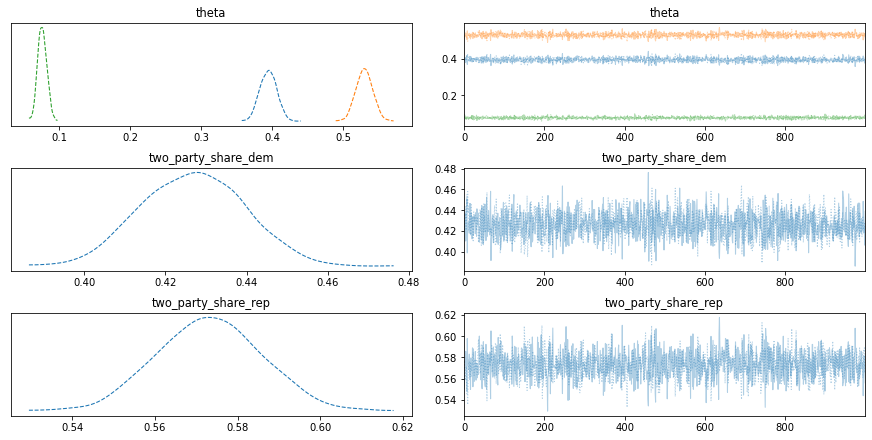

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


alaska


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


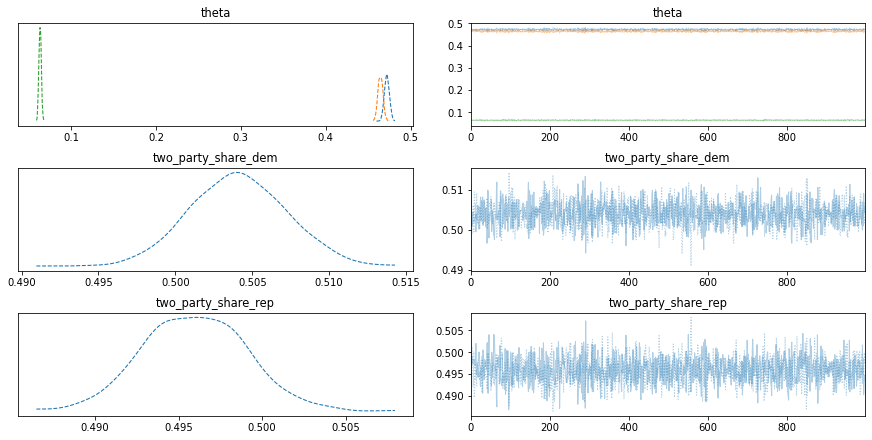

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


arizona


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


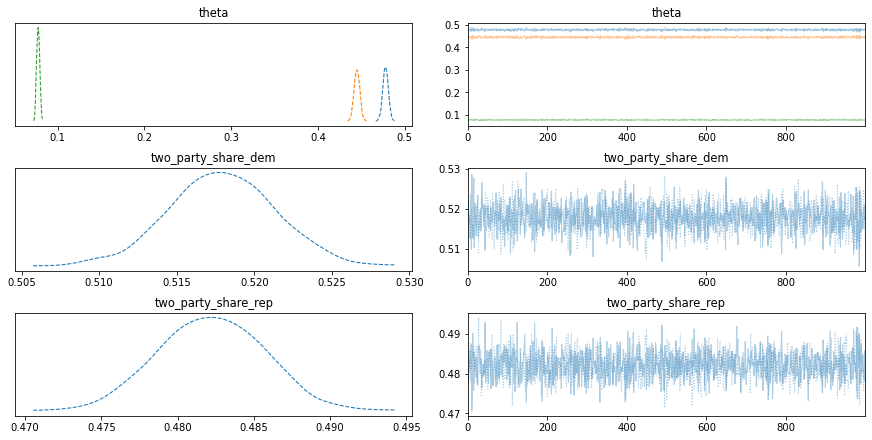

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


arkansas


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


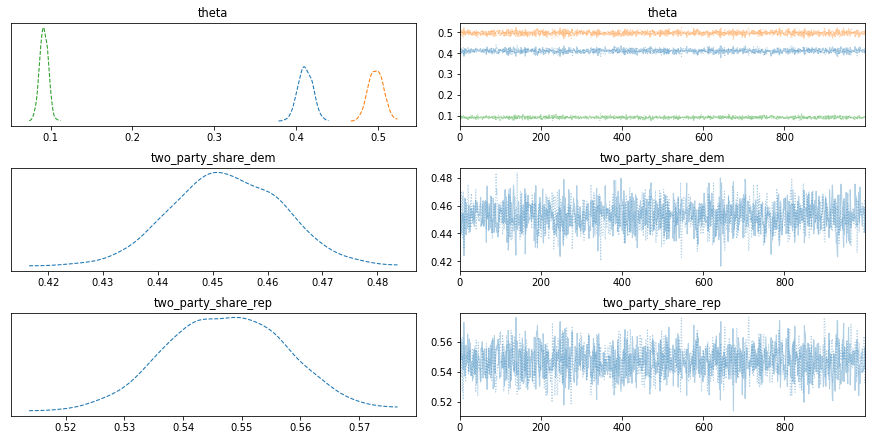

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


california


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


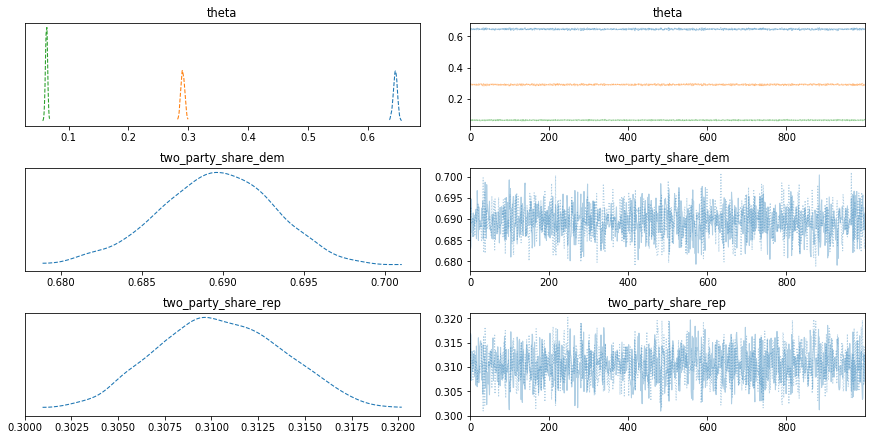

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


colorado


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


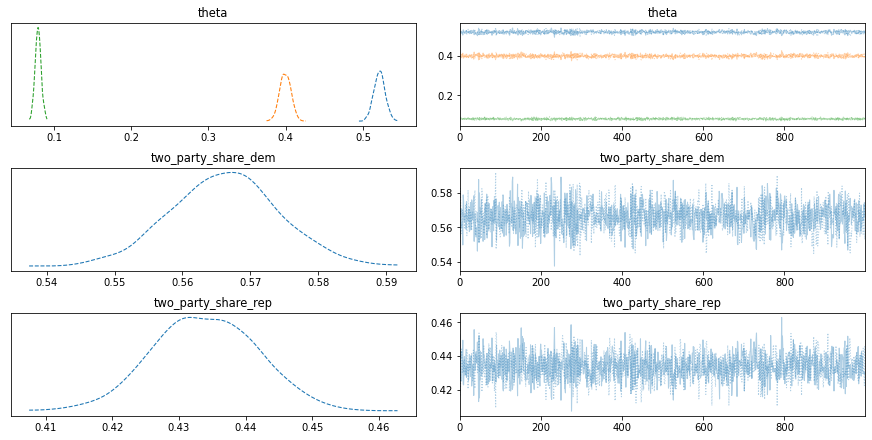

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


connecticut


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


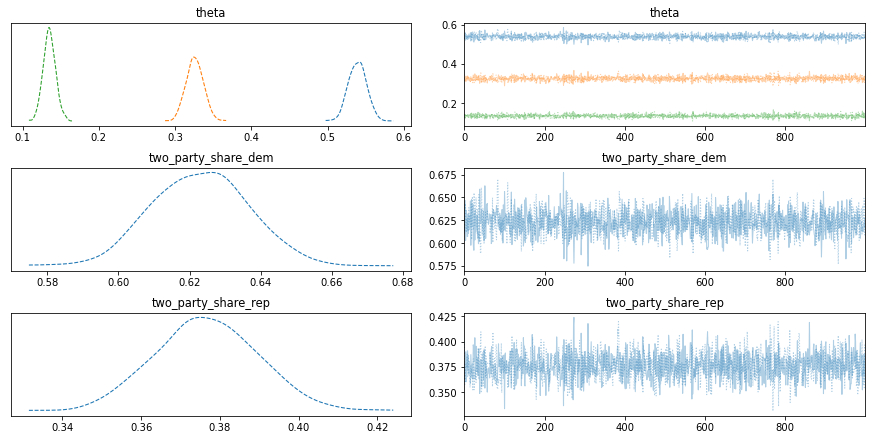

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


delaware


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


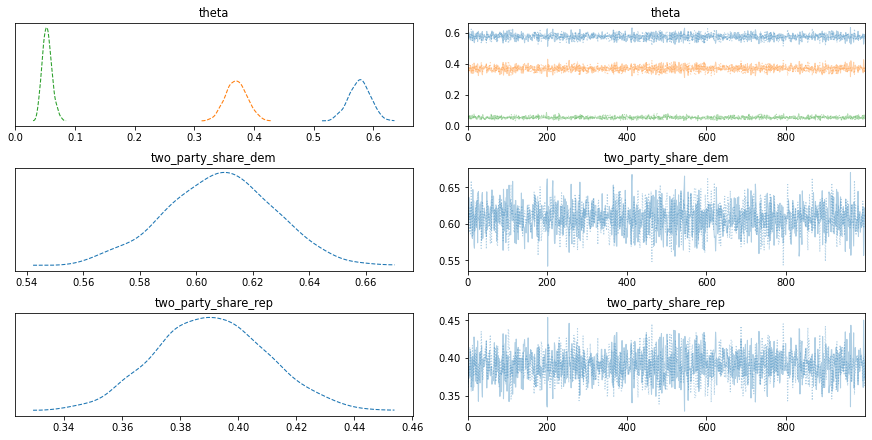

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


florida


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


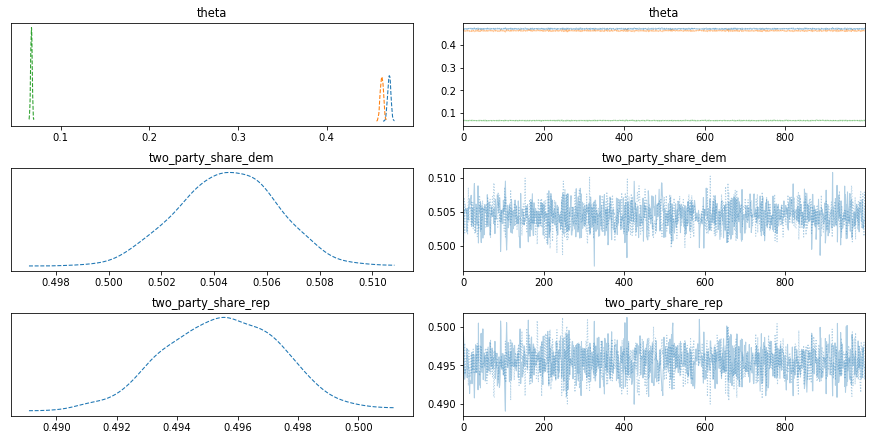

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


georgia


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


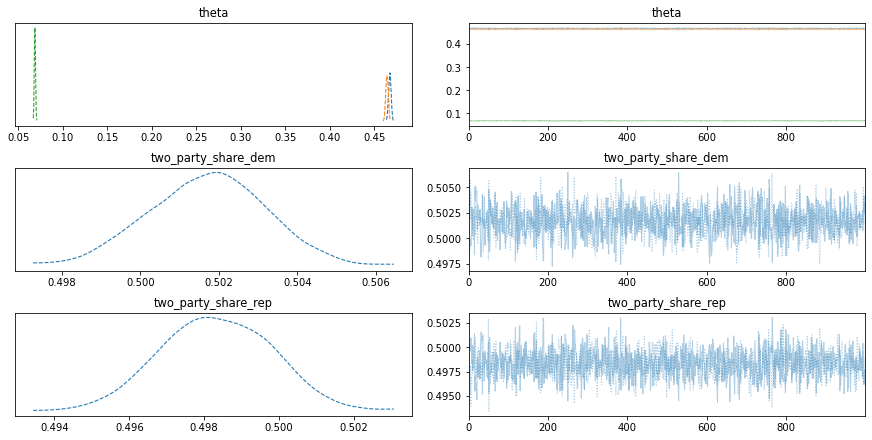

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


hawaii


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


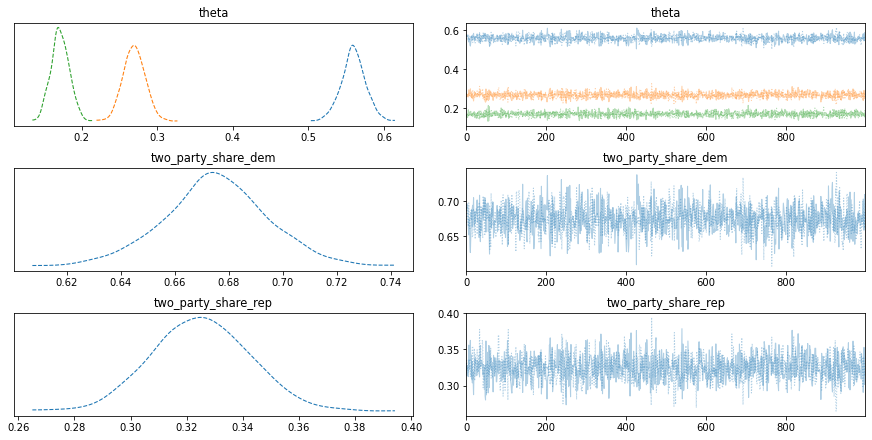

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


idaho


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


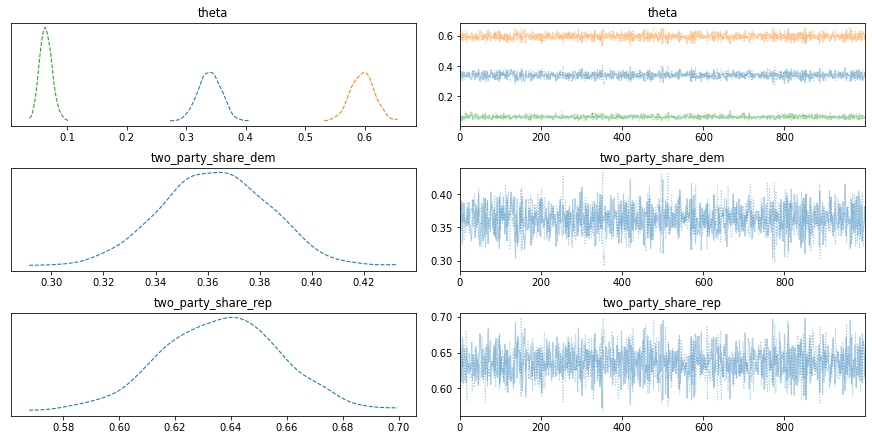

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


illinois


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


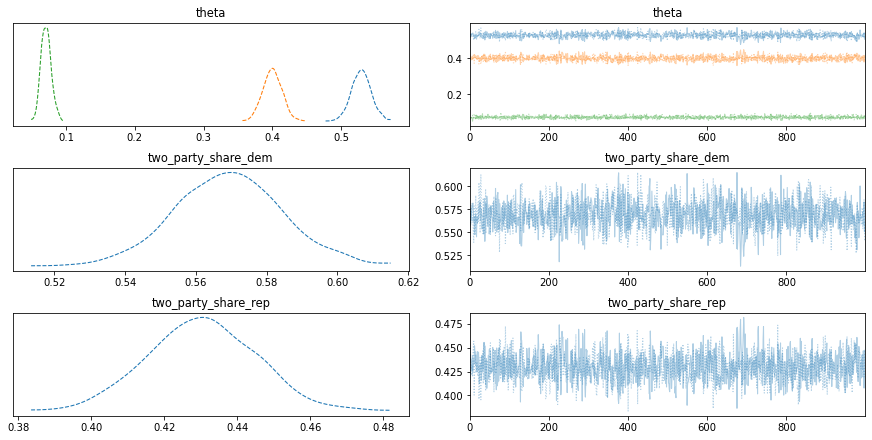

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


indiana


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


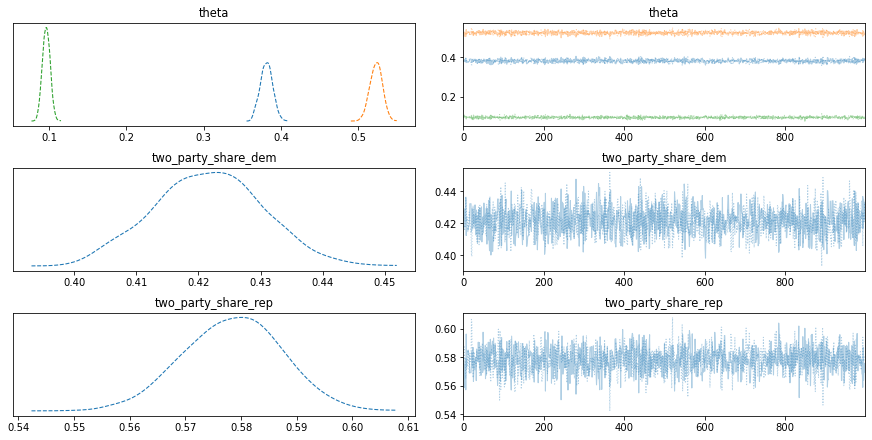

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


iowa


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


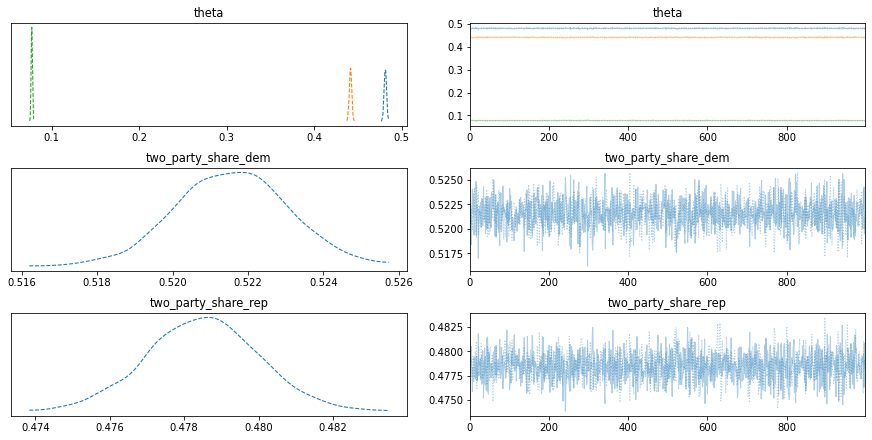

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


kansas


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


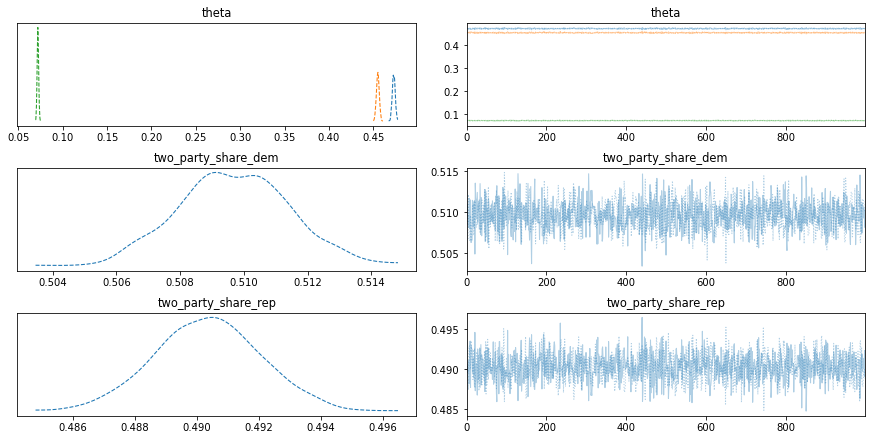

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


kentucky


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


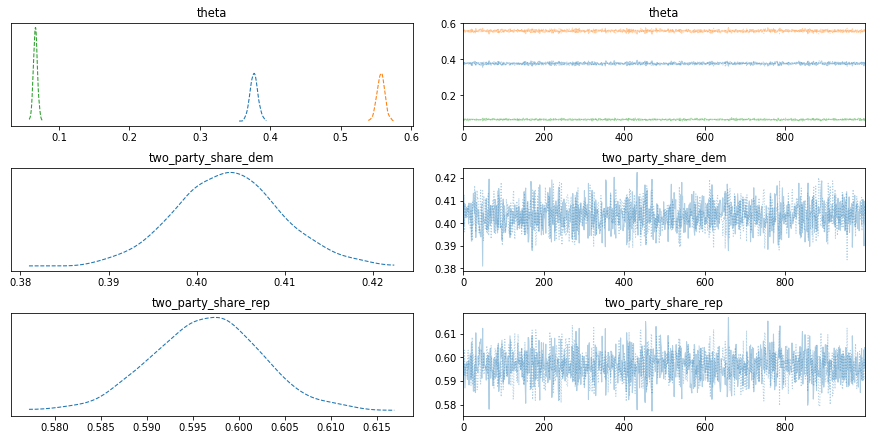

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


louisiana


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


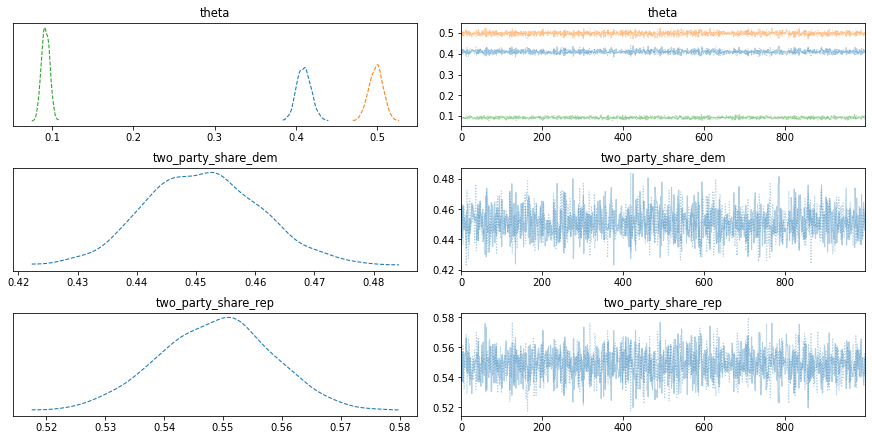

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


maine


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


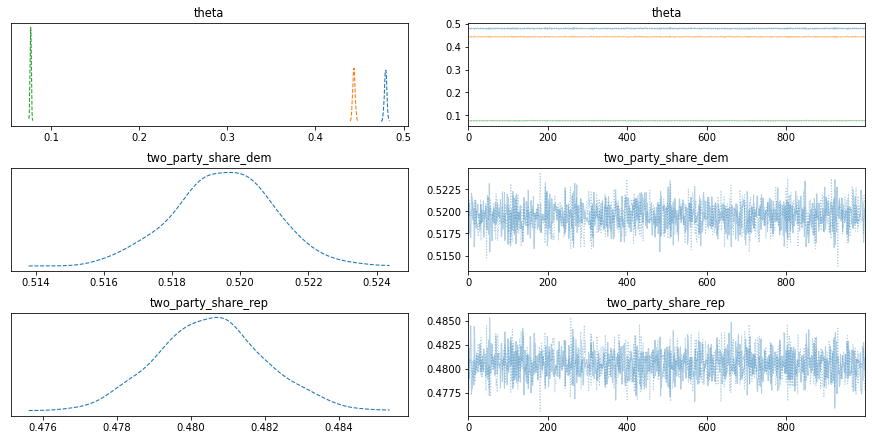

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


maryland


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


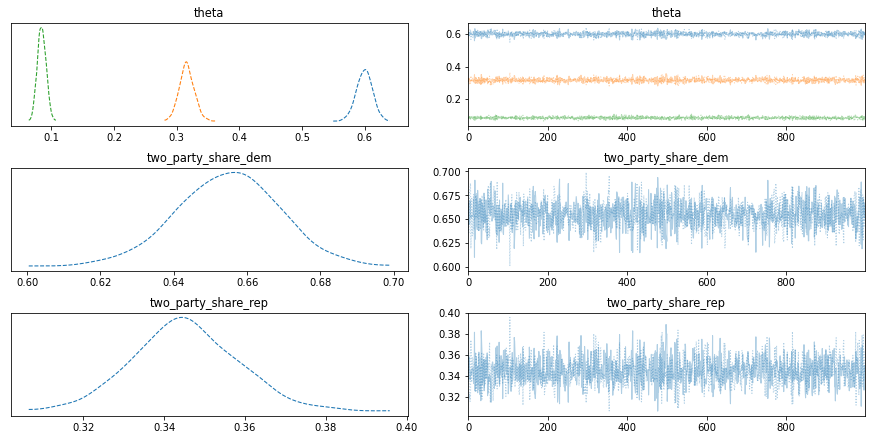

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


massachusetts


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


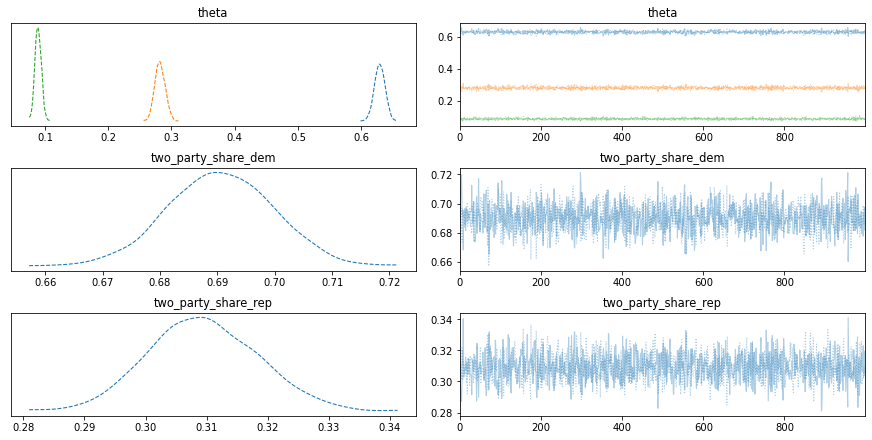

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


michigan


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


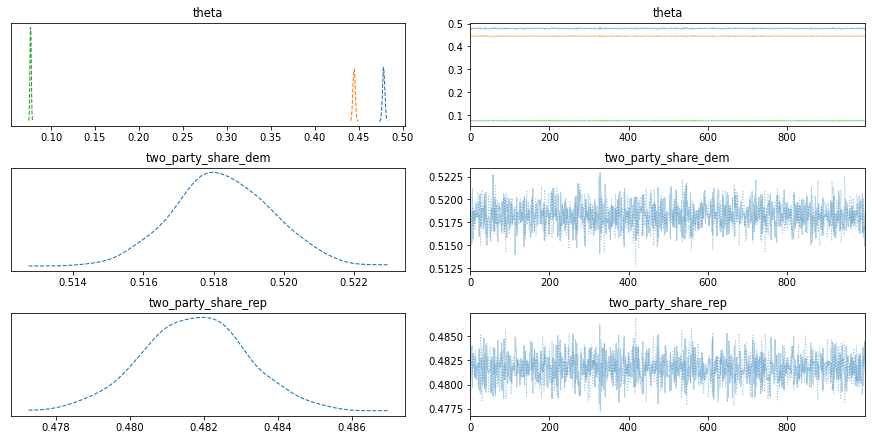

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


minnesota


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


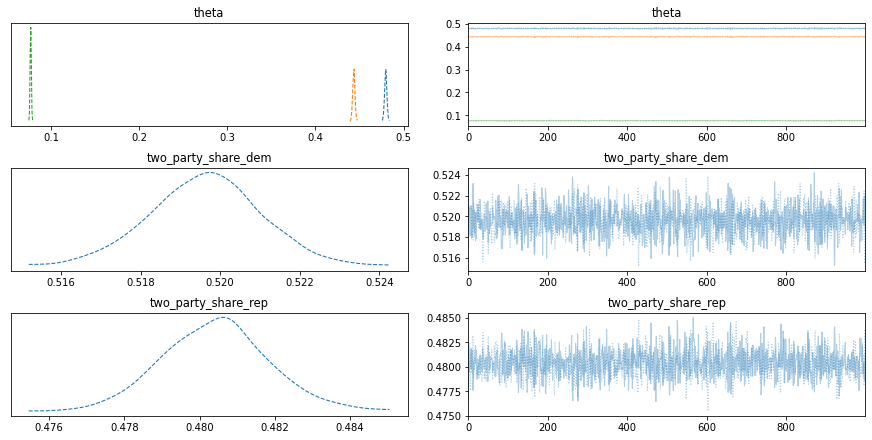

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


mississippi


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


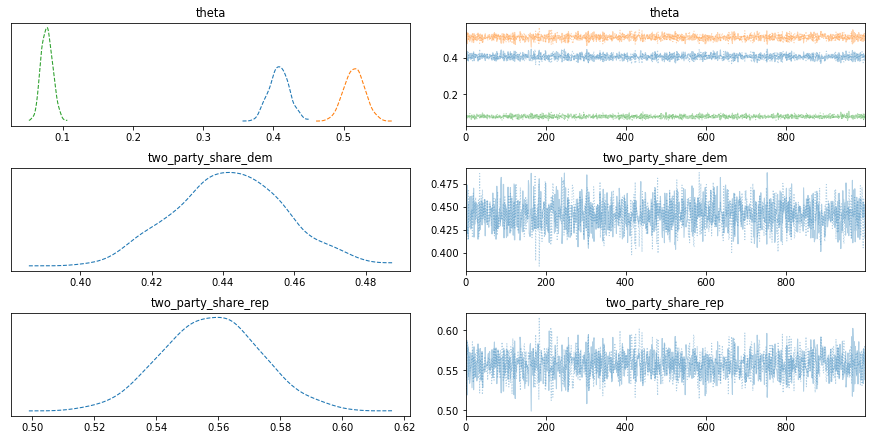

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


missouri


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


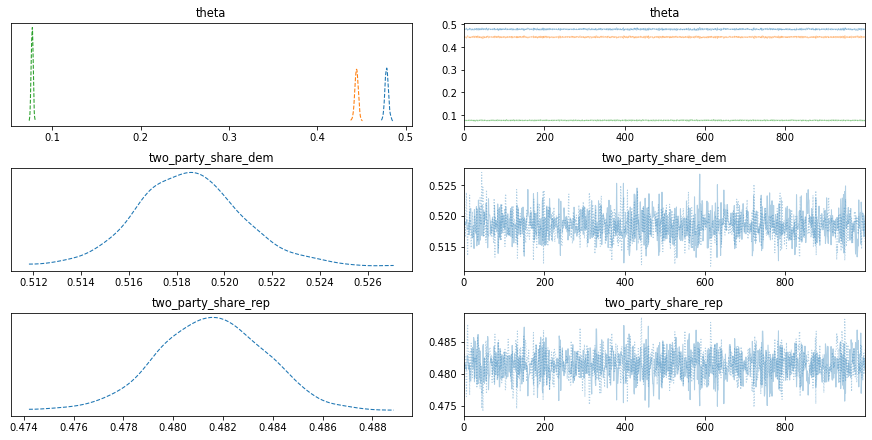

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


montana


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


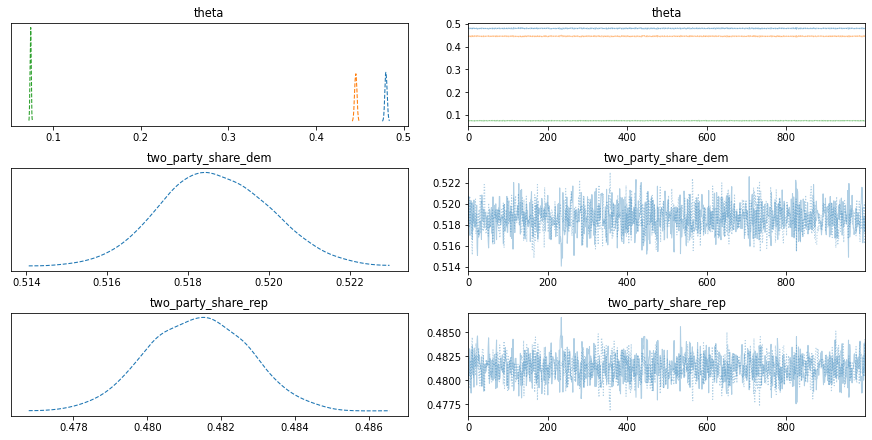

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


nebraska


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


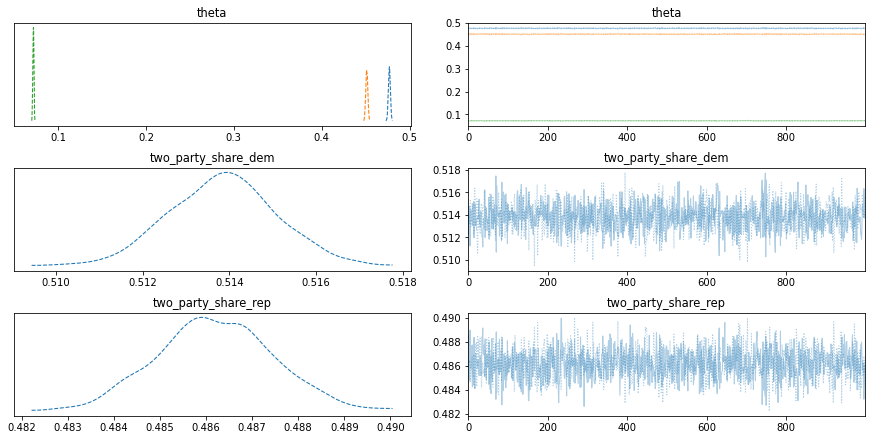

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


nevada


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


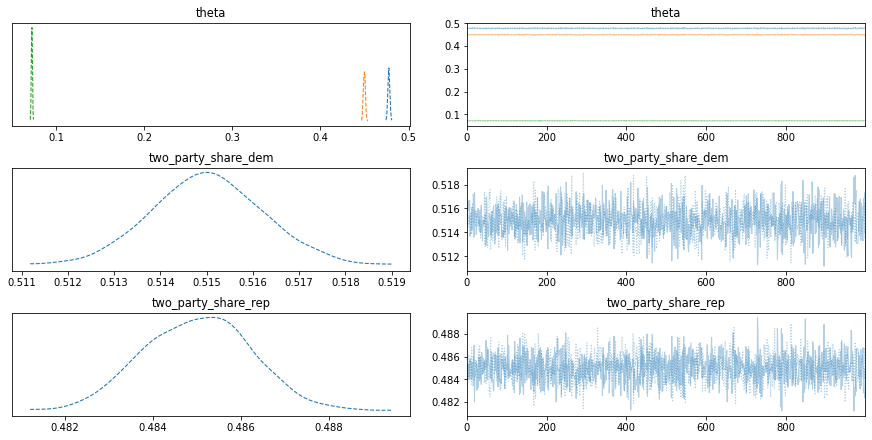

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


new-hampshire


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


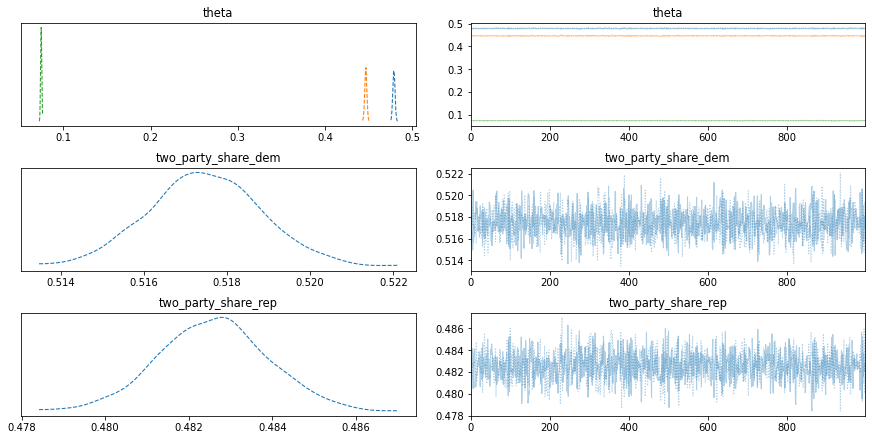

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


new-jersey


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


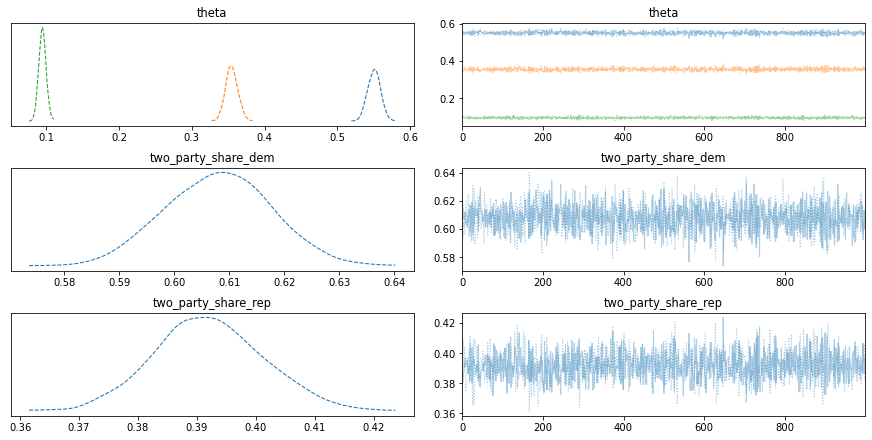

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


new-mexico


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


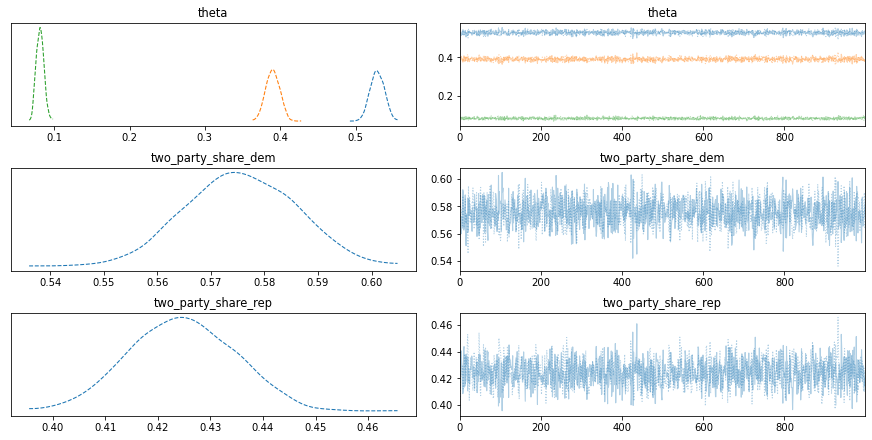

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


new-york


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


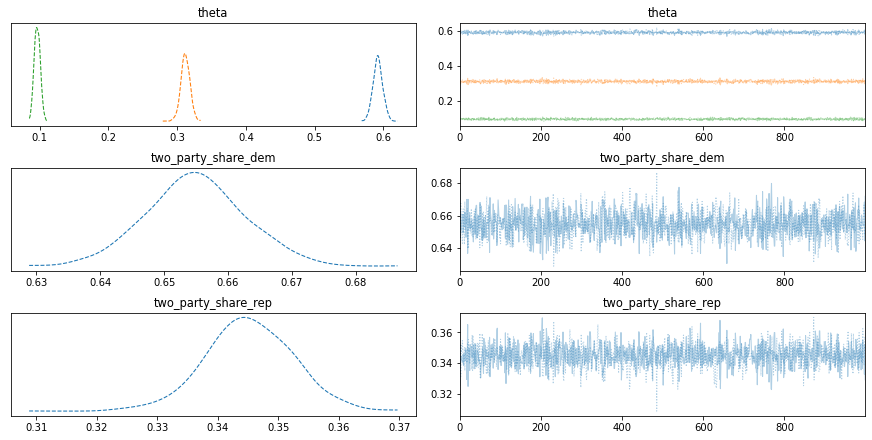

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


north-carolina


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


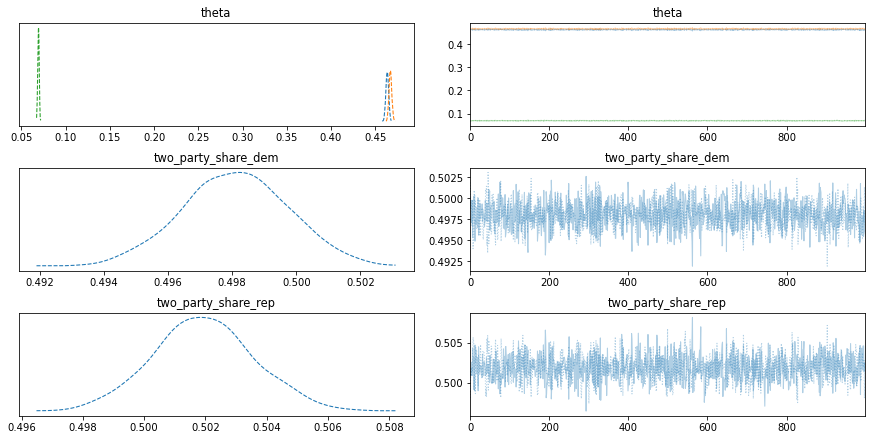

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


north-dakota


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


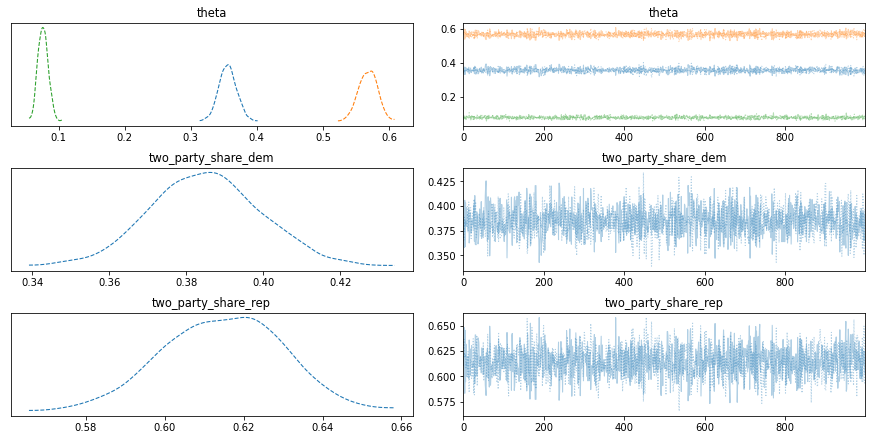

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ohio


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


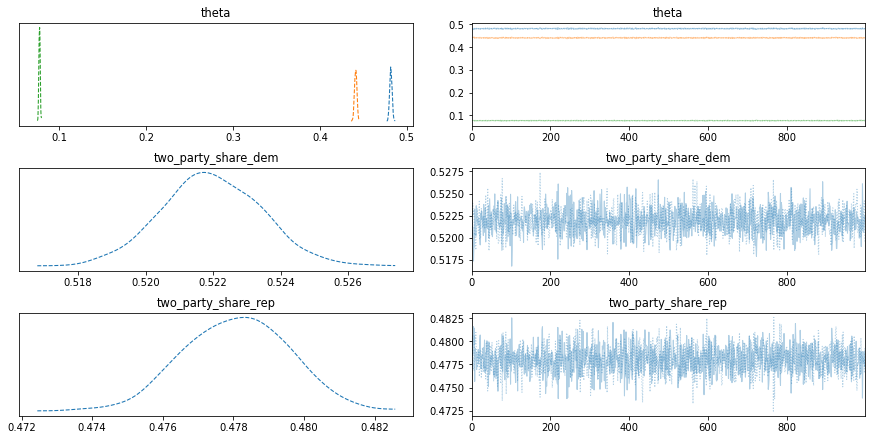

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


oklahoma


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


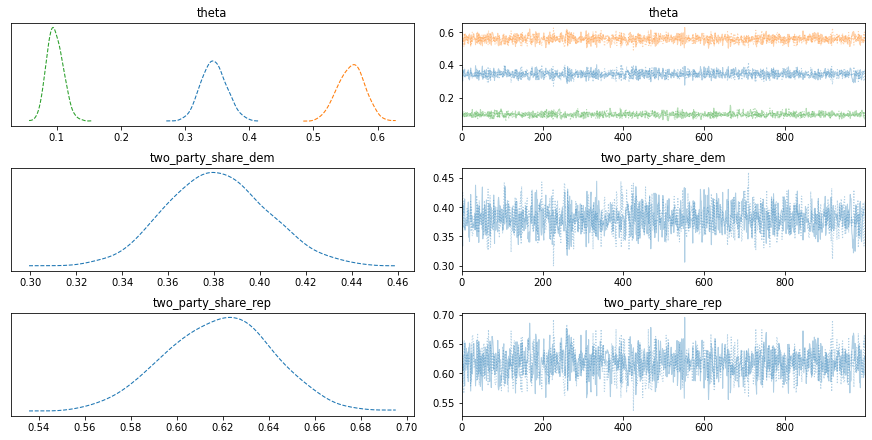

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


oregon


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


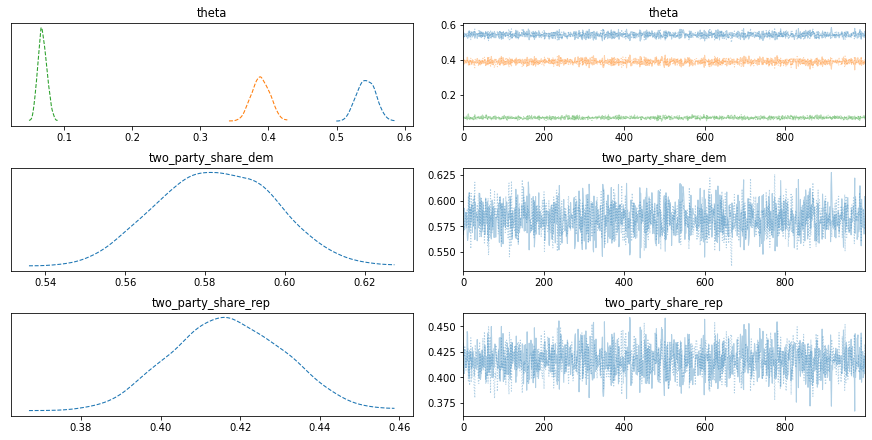

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


pennsylvania


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


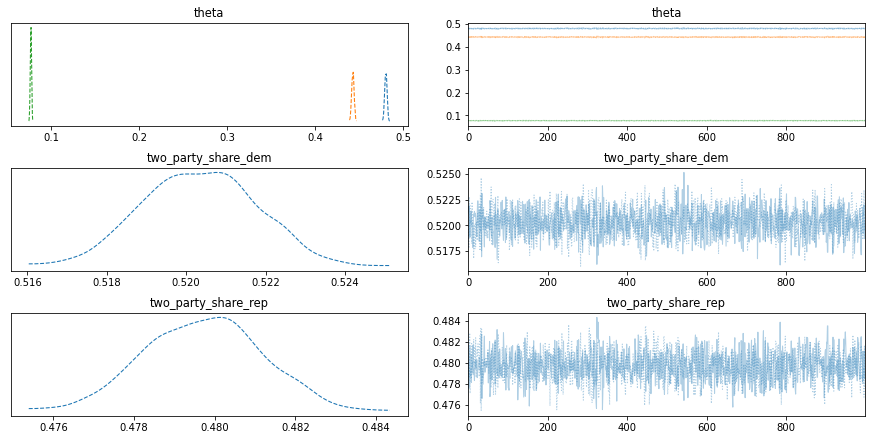

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


rhode-island


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


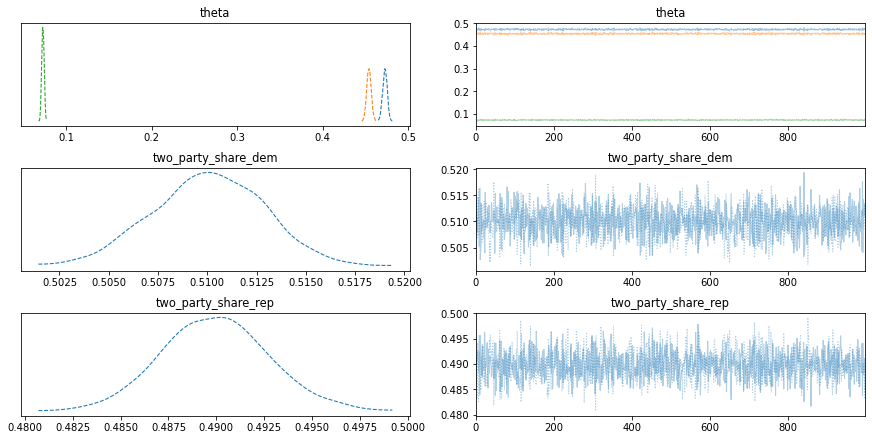

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


south-carolina


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


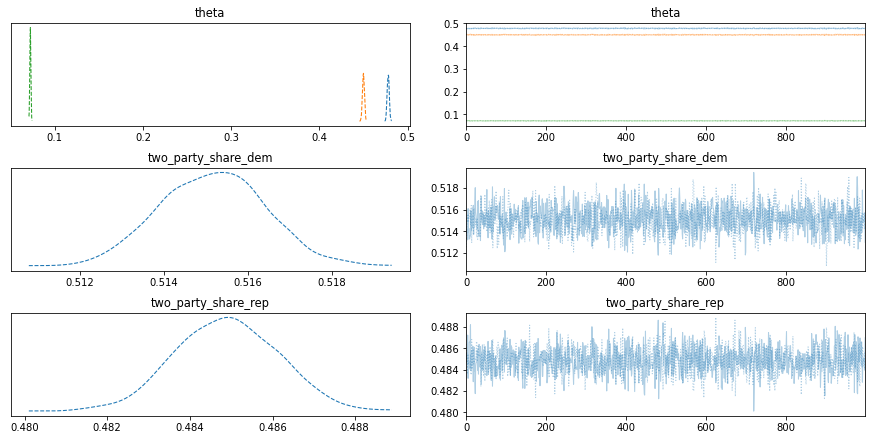

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


south-dakota


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


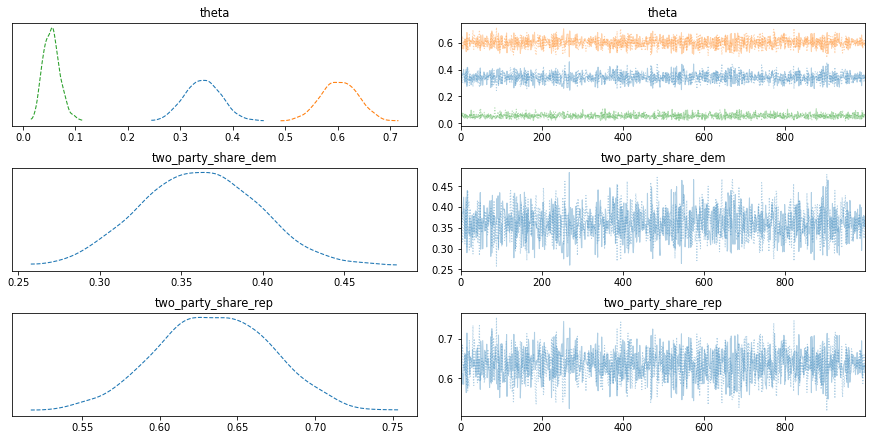

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


tennessee


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


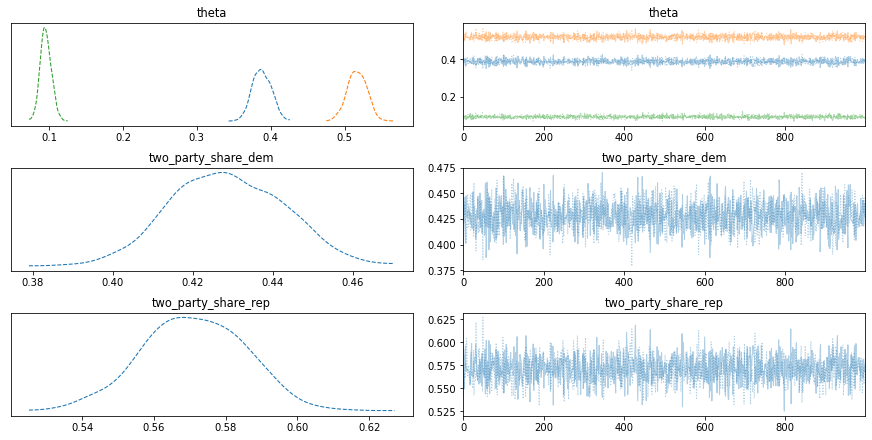

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


texas


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


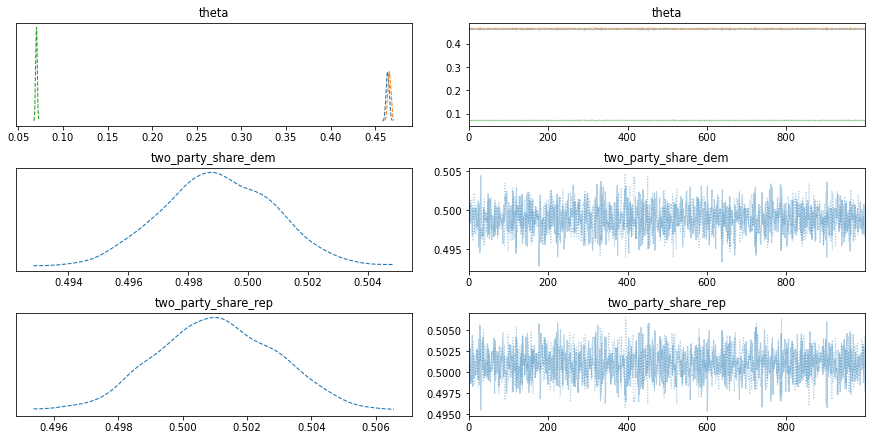

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


utah


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


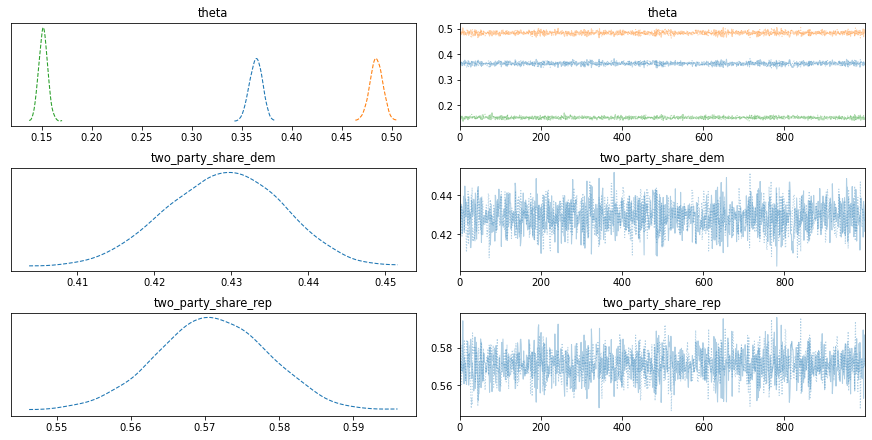

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


vermont


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


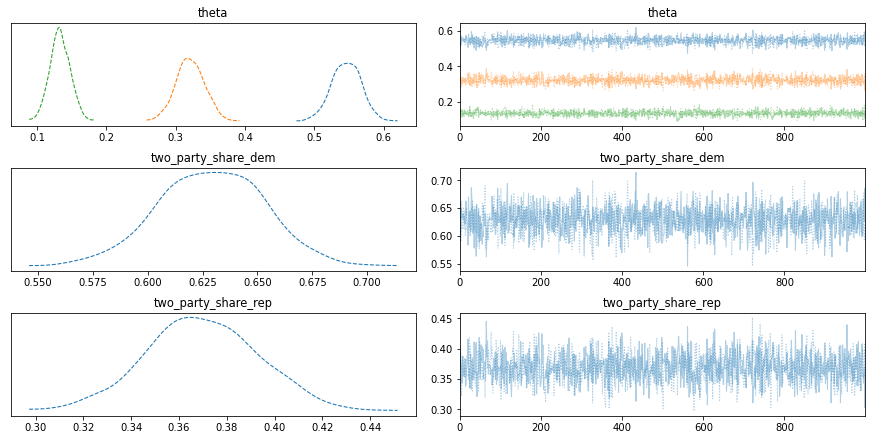

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


virginia


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


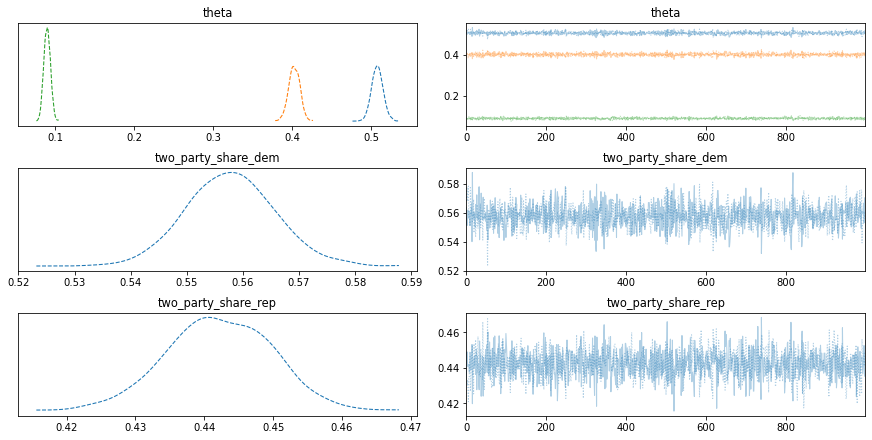

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


washington


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


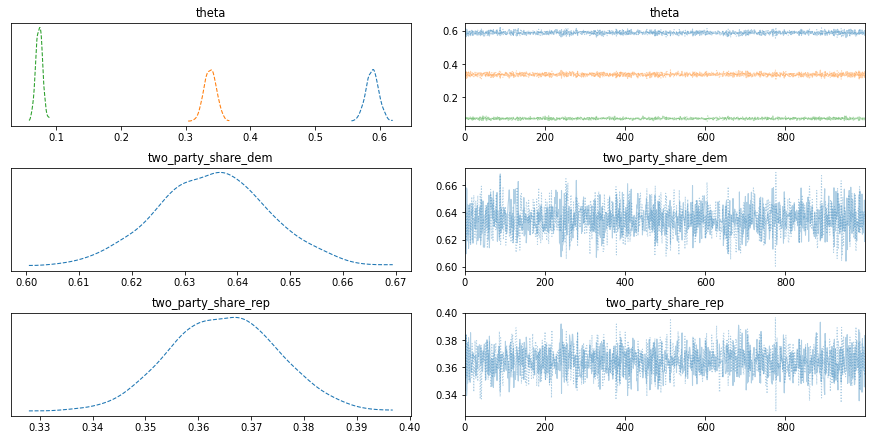

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


wisconsin


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


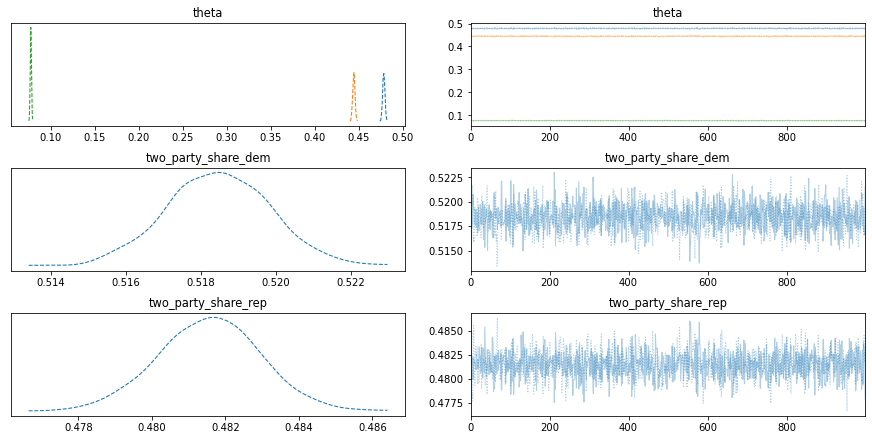

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


wyoming


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


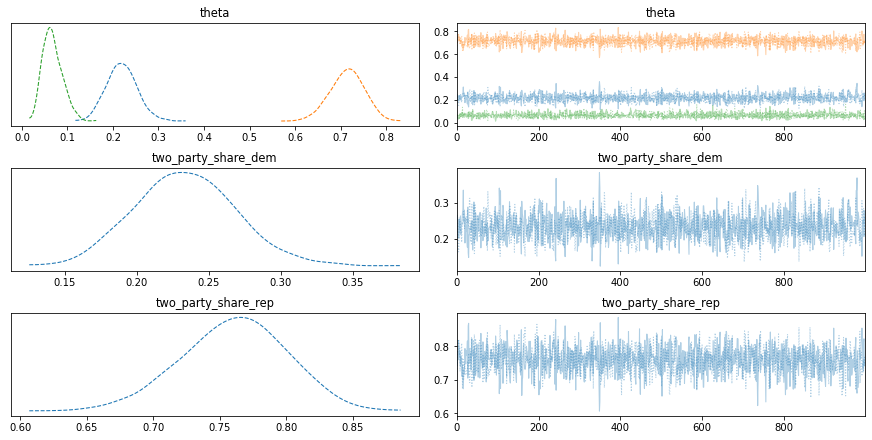

In [16]:
results_trace = {}
results_df = pd.DataFrame()
for state in sorted(df.race.unique()):
    state = state
    corr_threshold = 0.9
    race_filter = [i for i in result_corr.loc[(result_corr['Corr']>corr_threshold)&(result_corr['State1']==state)]['State1'].unique()] + [i for i in result_corr.loc[(result_corr['Corr']>0.75)&(result_corr['State1']==state)]['State2'].unique()]
    df_filter = df.loc[df.race.isin(race_filter)]
    result_corr_filter = result_corr.loc[result_corr['State1']==state].rename(columns={'State2':'race'})[['race','Corr']]
    df_filter = pd.merge(df_filter,result_corr_filter,left_on='race',right_on='race')
    df_filter['rep_success'],df_filter['dem_success'],df_filter['other_success'] = np.round(df_filter['rep_success']*df_filter['Corr']),np.round(df_filter['dem_success']*df_filter['Corr']),np.round(df_filter['other_success']*df_filter['Corr'])
    y = df_filter.append(df.loc[df['race']==state])[['dem_success','rep_success','other_success']].sum(axis=0).values
    n = y.sum()
    m = y[:2].sum()
    
    with pm.Model() as polling_model:
    
        # initializes the Dirichlet distribution with a prior of previous polls:
        a = np.ones((1,3))

        theta = pm.Dirichlet("theta", a=a, shape= (1,3))

        two_party_share_dem = pm.Deterministic("two_party_share_dem", theta[:, 0] * n / m)

        two_party_share_rep = pm.Deterministic("two_party_share_rep", theta[:, 1] * n / m)

        responses = pm.Multinomial("responses", n=n, p=theta, observed=y)
        
    with polling_model:
        print(state)
        polling_trace = pm.sample(draws=1000)
        results_trace[state] = [polling_model,
                                polling_trace]
        results_df = results_df.append(pd.DataFrame(polling_trace["theta"].mean(axis=0),columns = ['dem','rep','ind'],index=[state]))
        pm.traceplot(polling_trace, combined=True)
        plt.show()

### Write df, result_corr, and result_df to csv files

In [17]:
df.to_csv('df.csv')
result_corr.to_csv('result_corr.csv')
results_df.to_csv('results_df.csv')

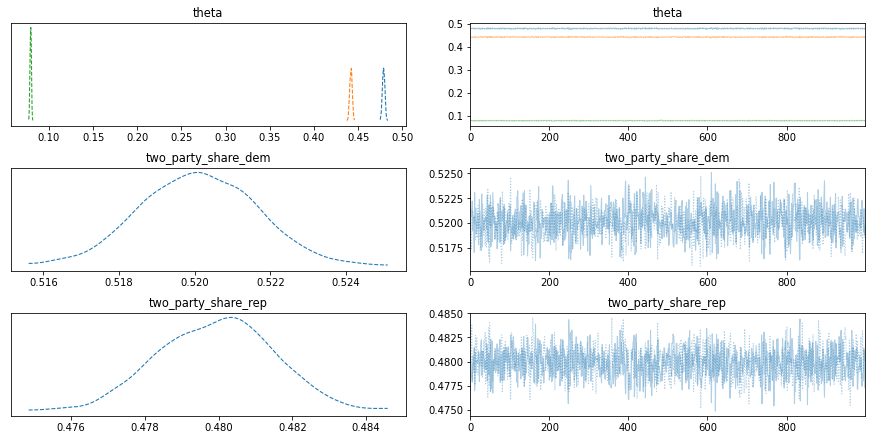

In [445]:
with polling_model:
    pm.traceplot(polling_trace, combined=True)

In [446]:
pd.DataFrame(polling_trace["theta"].mean(axis=0),columns = ['dem','rep','ind'],index=['vote_share'])

dem       rep       ind
vote_share  0.478792  0.441817  0.079391